# Evaluation and analysis of results

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import textwrap

In [188]:
# load data
question_data = pd.read_excel("/home/maria/STUDIUM/Master/5.Semester/Seminar/llmSeminar/data/questions_overview_answerFromTable.xlsx")
results_b1 = pd.read_excel("/home/maria/STUDIUM/Master/5.Semester/Seminar/llmSeminar/data/predictions/preds_answerFromTable_b1.xlsx")
results_b2 = pd.read_excel("/home/maria/STUDIUM/Master/5.Semester/Seminar/llmSeminar/data/predictions/preds_answerFromTable_b2.xlsx")
results_mcot = pd.read_excel("/home/maria/STUDIUM/Master/5.Semester/Seminar/llmSeminar/data/predictions/preds_answerFromTable_mcot.xlsx")


In [189]:
# concat evaluation of results to metadata df
results_df = pd.concat([question_data, pd.Series(list(results_b1["correct"]), name='correct_b1'), pd.Series(list(results_b2["correct"]), name='correct_b2'), pd.Series(list(results_mcot["correct"]), name='correct_mcot')], axis=1)
results_df.head()

,index,table_uid,question_uid,answer_from,category,category_finegrained,note,table_col_no,table_row_no,table_colxrow,...,filename_B2,correctly_solved_B1,problem_B1,correctly_solved_B2,problem_B2,correctly_solved_mCoT,problem_mCoT,correct_b1,correct_b2,correct_mcot
0,83,f3c0118e-20f3-416c-a52b-b3a7743bc1a7,921d80d2-1ea6-4c31-bf06-6393e5ca70ab,table,span (no comparison),span (no comparison),NaN,4,11,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
1,53,ee234fba-b422-4f1e-b383-721e1fbf8a1f,82233a8d-8e3d-4d17-ae97-ba62b4a8ba70,table,arithmetic,total,NaN,4,16,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,True
2,70,1b2cae74-b655-4f51-a080-6424534ed1ea,32302c33-8761-4f54-9ca6-b6c1efc2e8d9,table,Multi-span,Multi-span,NaN,3,20,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,45,1860a2e9-4ce1-4f18-bd9b-f84fd2ef62aa,e604014a-4498-4c15-be8b-de955b3a2607,table,arithmetic,ratio,NaN,3,10,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,44,4641a881-604b-4a96-8900-a058abdac0ac,eff067ee-a81b-4831-be56-7f026f781434,table,arithmetic,ratio,difference of ratios,4,19,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [190]:
results_b1["design"] = "Baseline 1 (simple zero-shot)"
results_b2["design"] = "Baseline 2 (zero-shot CoT)"
results_mcot["design"] = "Manual CoT"
results_df_long = pd.concat([results_b1, results_b2, results_mcot])
results_df_long.columns

Index(['question_uid', 'gptAnswer', 'extractedAnswer', 'derivation', 'label',
       'scale', 'note', 'correct', 'problem', 'ValueDetectionError',
       'ScaleError', 'FormulaError', 'CalculationError', 'RoundingError',
       'MissingCalculationError', 'MisunderstandingError', 'OtherError',
       'design'],
      dtype='object')

In [191]:
results_df = pd.merge(results_df_long, question_data, on='question_uid', how='outer')

In [192]:
results_df['category_finegrained'].unique()

array(['span (no comparison)', 'total', 'Multi-span', 'ratio',
       'percentage of', 'percentage change', 'difference', 'average',
       'span (requires comparison)', 'count'], dtype=object)

In [194]:
results_df['category_finegrained'] = results_df['category_finegrained'].replace(['span (no comparison)', "span (requires comparison)", 'Multi-span'], ['lookup 1 (no comp.)', "lookup 1 (comp.)", 'lookup >1'])
results_df['table_size'] = results_df['table_small'].replace([True, False], ['small tables', "large tables"])

In [195]:
# reorder levels of question category (-> define order to be shown in plot)
question_categories = ["lookup 1 (no comp.)", "lookup 1 (comp.)", "lookup >1", "count", "total", "difference", "ratio", "percentage of", "percentage change", "average"]
results_df["category_finegrained"] = pd.Categorical(results_df["category_finegrained"], categories = question_categories)

# reorder levels of table size (-> define order to be shown in plot)
table_sizes = ["small tables", "large tables"]
results_df["table_size"] = pd.Categorical(results_df["table_size"], categories = table_sizes)


In [196]:
results_df[(results_df["design"]== "Baseline 1 (simple zero-shot)") & (results_df["category_finegrained"] == "lookup 1 (no comp.)")].correct.value_counts()

correct
True    10
Name: count, dtype: int64

In [198]:
error_types = ["ValueDetectionError", "ScaleError", "FormulaError", "CalculationError", "RoundingError", "MissingCalculationError", "MisunderstandingError", "OtherError"]

for cat in question_categories:
    print(cat)
    for error in error_types:
        error_percent = results_df[(results_df["correct"]==False) & (results_df.category_finegrained == cat)][error].mean() * 100
        if (error_percent != 0):
            print(f"{error_percent} % {error}")
    print("\n")

lookup 1 (no comp.)
50.0 % ValueDetectionError
50.0 % MisunderstandingError


lookup 1 (comp.)
33.33333333333333 % ValueDetectionError
66.66666666666666 % MisunderstandingError


lookup >1
16.666666666666664 % ValueDetectionError
11.11111111111111 % ScaleError
5.555555555555555 % MissingCalculationError
55.55555555555556 % MisunderstandingError
11.11111111111111 % OtherError


count
80.0 % ValueDetectionError
20.0 % OtherError


total
11.76470588235294 % ValueDetectionError
29.411764705882355 % ScaleError
23.52941176470588 % FormulaError
17.647058823529413 % MissingCalculationError
23.52941176470588 % MisunderstandingError
5.88235294117647 % OtherError


difference
25.0 % ValueDetectionError
16.666666666666664 % ScaleError
66.66666666666666 % FormulaError


ratio
53.333333333333336 % ValueDetectionError
60.0 % FormulaError
20.0 % CalculationError
6.666666666666667 % MissingCalculationError


percentage of
30.76923076923077 % ValueDetectionError
69.23076923076923 % RoundingError


perce

In [213]:
error_perc_df = [['category_finegrained','error_type','error_percent']]


#df = pd.DataFrame(data[1:],columns=data[0])


for cat in question_categories:
    for error in error_types:
        error_percent = results_df[(results_df["correct"]==False) & (results_df.category_finegrained == cat)][error].mean() * 100
        row = [cat, error, error_percent]
        
        error_perc_df.append(row)

error_perc_df = pd.DataFrame(error_perc_df[1:],columns=error_perc_df[0])



,category_finegrained,error_type,error_percent
0,lookup 1 (no comp.),ValueDetectionError,50.0
1,lookup 1 (no comp.),ScaleError,0.0
2,lookup 1 (no comp.),FormulaError,0.0
3,lookup 1 (no comp.),CalculationError,0.0
4,lookup 1 (no comp.),RoundingError,0.0


In [215]:
# reorder levels of question category (-> define order to be shown in plot)

error_perc_df["category_finegrained"] = pd.Categorical(error_perc_df["category_finegrained"], categories = question_categories)

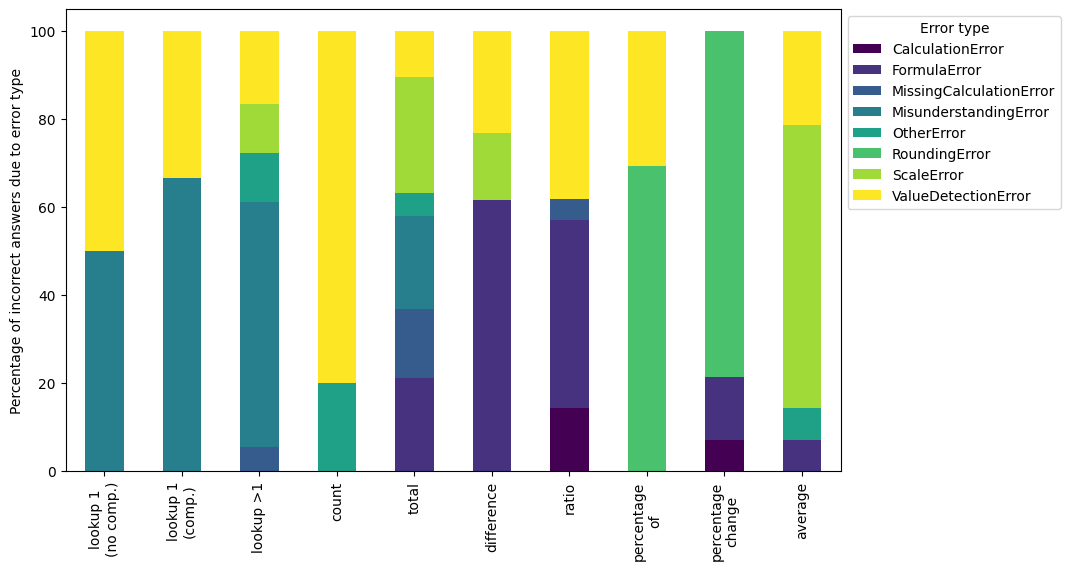

In [219]:
# Pivot the DataFrame for easy plotting
pivot_df = error_perc_df.pivot(index='category_finegrained', columns='error_type', values='error_percent')

# Normalize each row to represent percentages
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')

# Add labels and title
plt.xlabel('')
plt.ylabel('Percentage of incorrect answers due to error type')
#plt.title('Stacked Bar Plot')

# Add legend
plt.legend(title='Error type', bbox_to_anchor=(1, 1))

labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)

# Show the plot
plt.show()


In [183]:
for error in ["ValueDetectionError", "ScaleError", "FormulaError", "CalculationError", "RoundingError", "MissingCalculationError", "MisunderstandingError", "OtherError"]:
    print(results_b1[results_b1["correct"]==False][error].value_counts(normalize = True))


results_b1[results_b1["correct"]==False].groupby(['category_finegrained'])[error].mean() * 100

ValueDetectionError
False    0.772727
True     0.227273
Name: proportion, dtype: float64
ScaleError
False    0.795455
True     0.204545
Name: proportion, dtype: float64
FormulaError
False    0.863636
True     0.136364
Name: proportion, dtype: float64
CalculationError
False    0.977273
True     0.022727
Name: proportion, dtype: float64
RoundingError
False    0.818182
True     0.181818
Name: proportion, dtype: float64
MissingCalculationError
False    0.931818
True     0.068182
Name: proportion, dtype: float64
MisunderstandingError
False    0.795455
True     0.204545
Name: proportion, dtype: float64
OtherError
False    0.931818
True     0.068182
Name: proportion, dtype: float64


KeyError: 'category_finegrained'

In [97]:
# percentage of correct/false answers

print(results_df.groupby(["design"])["correct"].value_counts(normalize=True))


design                         correct
Baseline 1 (simple zero-shot)  True       0.56
                               False      0.44
Baseline 2 (zero-shot CoT)     True       0.65
                               False      0.35
Manual CoT                     True       0.63
                               False      0.37
Name: proportion, dtype: float64


<Axes: xlabel='design'>

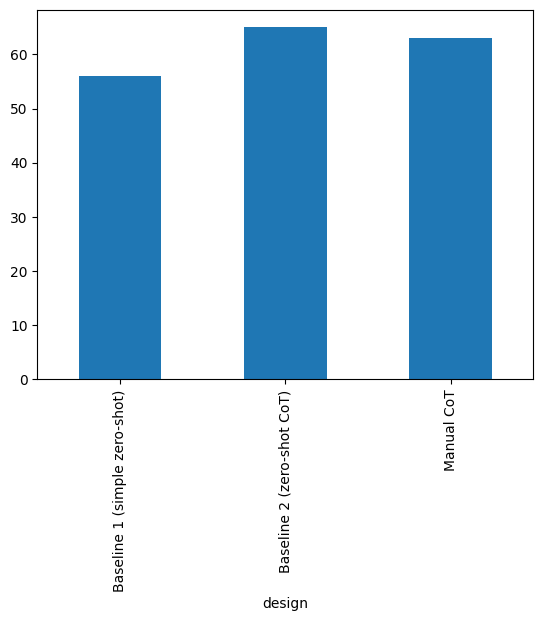

In [88]:
results_df[results_df.correct == True].groupby(['design']).size().plot(kind = "bar")

### results by table size

In [112]:
# percentage of correct answers / tabel size
grouped_df_tabSize = results_df.groupby(["table_size", 'design'])['correct'].mean() * 100

/tmp/ipykernel_73447/810143587.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_tabSize = results_df.groupby(["table_size", 'design'])['correct'].mean() * 100


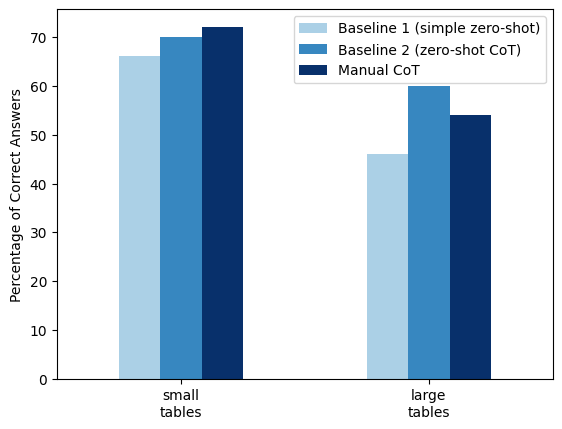

In [114]:
unique_values_cat = results_df['design'].unique()

# Create a color map for each unique value in column A
color_dict = {value: plt.cm.Blues_r((len(unique_values_cat) - i - 1) / len(unique_values_cat)) for i, value in enumerate(unique_values_cat)}

# Map the colors to the groups in column A
grouped_df_colors = results_df['design'].map(color_dict)


# Plot the bar chart with different colors for each unique value in column A
#ax = grouped_df_tabSize.unstack('design').plot(kind='bar', ylabel='Percentage of Correct Answers',
#                             title='Percentage of correct answers per design and table size', color=grouped_df_colors)

ax = grouped_df_tabSize.unstack('design').plot(kind='bar', ylabel='Percentage of Correct Answers', color=grouped_df_colors)


ax.legend(title='', loc='upper right')  # Hide legend title

labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)
ax.xaxis.set_tick_params(rotation=0)


ax.set_xlabel('')  # Hide x-axis label
# Show the plot
plt.show()

### results by category

In [115]:
# percentage of correct answers / category
grouped_df = results_df.groupby(["category_finegrained", 'design'])['correct'].mean() * 100

grouped_df_smallTab = results_df[results_df["table_small"] == True].groupby(["category_finegrained", 'design'])['correct'].mean() * 100
grouped_df_largeTab = results_df[results_df["table_small"] == False].groupby(["category_finegrained", 'design'])['correct'].mean() * 100

/tmp/ipykernel_73447/3680504151.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = results_df.groupby(["category_finegrained", 'design'])['correct'].mean() * 100
/tmp/ipykernel_73447/3680504151.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_smallTab = results_df[results_df["table_small"] == True].groupby(["category_finegrained", 'design'])['correct'].mean() * 100
/tmp/ipykernel_73447/3680504151.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

In [64]:
grouped_df.columns

AttributeError: 'Series' object has no attribute 'columns'

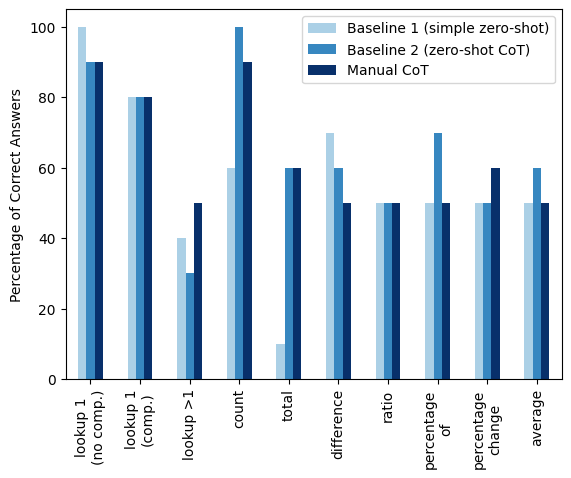

In [117]:
unique_values_cat = results_df['design'].unique()

# Create a color map for each unique value in column A
color_dict = {value: plt.cm.Blues_r((len(unique_values_cat) - i - 1) / len(unique_values_cat)) for i, value in enumerate(unique_values_cat)}

# Map the colors to the groups in column A
grouped_df_colors = results_df['design'].map(color_dict)


# Plot the bar chart with different colors for each unique value in column A
#ax = grouped_df.unstack('design').plot(kind='bar', ylabel='Percentage of Correct Answers',
#                             title='Percentage of correct answers per design and category', color=grouped_df_colors)

ax = grouped_df.unstack('design').plot(kind='bar', ylabel='Percentage of Correct Answers', color=grouped_df_colors)


ax.legend(title='', loc='upper right')  # Hide legend title

labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)



ax.set_xlabel('')  # Hide x-axis label
# Show the plot
plt.show()

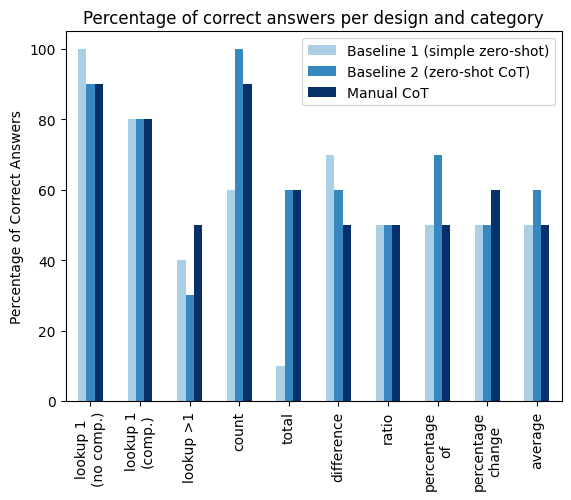

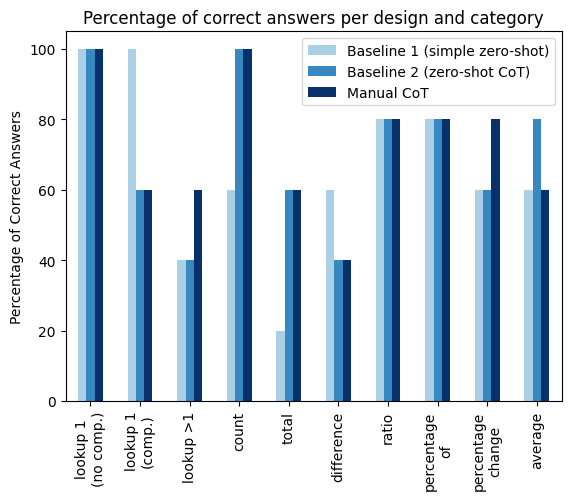

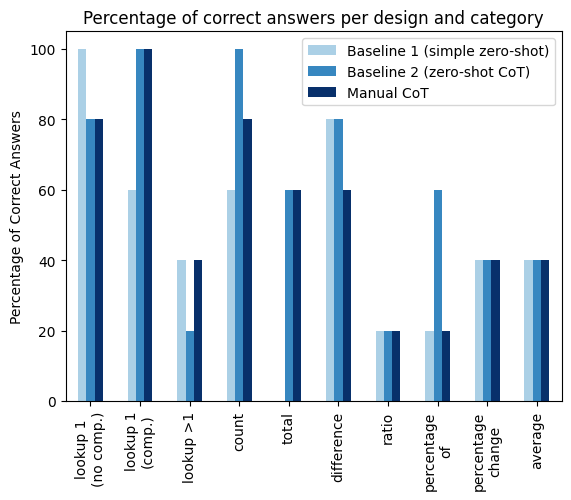

In [76]:
for df in [grouped_df, grouped_df_smallTab, grouped_df_largeTab]:
    
    unique_values_cat = results_df['design'].unique()

    # Create a color map for each unique value in column A
    color_dict = {value: plt.cm.Blues_r((len(unique_values_cat) - i - 1) / len(unique_values_cat)) for i, value in enumerate(unique_values_cat)}

    # Map the colors to the groups in column A
    grouped_df_colors = results_df['design'].map(color_dict)


    # Plot the bar chart with different colors for each unique value in column A
    ax = df.unstack('design').plot(kind='bar', ylabel='Percentage of Correct Answers',
                                title='Percentage of correct answers per design and category', color=grouped_df_colors)


    ax.legend(title='', loc='upper right')  # Hide legend title

    labels = [item.get_text() for item in ax.get_xticklabels()]
    wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
    ax.set_xticklabels(wrapped_labels)



    ax.set_xlabel('')  # Hide x-axis label
    # Show the plot
    plt.show()

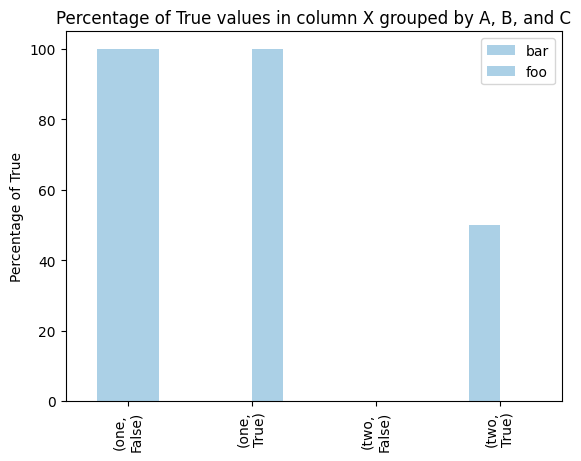

In [87]:


# Example DataFrame with an additional binary variable 'C'
data = {'A': ['foo', 'foo', 'bar', 'bar', 'foo', 'bar'],
        'B': ['one', 'one', 'two', 'two', 'two', 'one'],
        'C': [True, False, True, True, False, False],  # Additional binary variable
        'X': [True, True, False, True, False, True]}

df = pd.DataFrame(data)

# Group by columns A, B, and C, calculate the percentage of True values in column X
grouped_df = df.groupby(['A', 'B', 'C'])['X'].mean() * 100

# Get unique values in columns A and C
unique_values_A = df['A'].unique()
unique_values_C = df['C'].unique()

# Create a dictionary mapping each unique value in column A to a shade of blue
color_dict_A = {value: plt.cm.Blues((i + 1) / (len(unique_values_A) + 1)) for i, value in enumerate(unique_values_A)}

# Map the colors to the groups in column A
grouped_df_colors_A = df['A'].map(color_dict_A)

# Map the colors to the groups in column C
color_dict_C = {True: 'red', False: 'blue'}
grouped_df_colors_C = df['C'].map(color_dict_C)

# Combine the colors based on columns A and C
grouped_df_colors = grouped_df_colors_A.combine_first(grouped_df_colors_C)

# Plot the bar chart with different shades of blue for each unique value in column A
# and differentiate the colors based on 'C' (red or blue)
ax = grouped_df.unstack('A').plot(kind='bar', ylabel='Percentage of True',
                                  title='Percentage of True values in column X grouped by A, B, and C', color=grouped_df_colors)

# Adjustments for the plot
ax.legend(title='', loc='upper right')  # Hide legend title

# Wrap x-axis labels with line breaks for long labels
labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)

ax.set_xlabel('')  # Hide x-axis label

# Show the plot
plt.show()


In [ ]:
# separately for small and larger tables

# percentage of correct answers / category
grouped_df_tabSize = results_df.groupby(["category_finegrained", "table_small", 'design'])['correct'].mean() * 100

unique_values_cat = results_df['design'].unique()

# Create a color map for each unique value in column A
color_dict = {value: plt.cm.Blues_r((len(unique_values_cat) - i - 1) / len(unique_values_cat)) for i, value in enumerate(unique_values_cat)}

# Map the colors to the groups in column A
grouped_df_colors = results_df['design'].map(color_dict)


# Plot the bar chart with different colors for each unique value in column A
ax = grouped_df.unstack('design').plot(kind='bar', ylabel='Percentage of Correct Answers',
                             title='Percentage of correct answers per design and category', color=grouped_df_colors)


ax.legend(title='', loc='upper right')  # Hide legend title

labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)



ax.set_xlabel('')  # Hide x-axis label
# Show the plot
plt.show()

In [37]:
# by table size

for i in ["correct_b1", "correct_b2", "correct_mcot"]:
    print(results_df.groupby(["table_small"])[i].value_counts(normalize=True))
    print("\n")


table_small  correct_b1
False        False         0.54
             True          0.46
True         True          0.66
             False         0.34
Name: proportion, dtype: float64


table_small  correct_b2
False        True          0.6
             False         0.4
True         True          0.7
             False         0.3
Name: proportion, dtype: float64


table_small  correct_mcot
False        True            0.54
             False           0.46
True         True            0.72
             False           0.28
Name: proportion, dtype: float64




In [38]:
# by category


for i in ["correct_b1", "correct_b2", "correct_mcot"]:
    print(results_df.groupby(["category"])[i].value_counts(normalize=True))
    print("\n")



category                    correct_b1
Multi-span                  False         0.600000
                            True          0.400000
arithmetic                  False         0.533333
                            True          0.466667
count                       True          0.600000
                            False         0.400000
span (no comparison)        True          1.000000
span (requires comparison)  True          0.800000
                            False         0.200000
Name: proportion, dtype: float64


category                    correct_b2
Multi-span                  False         0.700000
                            True          0.300000
arithmetic                  True          0.583333
                            False         0.416667
count                       True          1.000000
span (no comparison)        True          0.900000
                            False         0.100000
span (requires comparison)  True          0.800000
                    

In [39]:
# by category (finegrained)
for i in ["correct_b1", "correct_b2", "correct_mcot"]:
    print(results_df.groupby(["category", "category_finegrained"])[i].value_counts(normalize=True))
    print("\n")


category                    category_finegrained        correct_b1
Multi-span                  Multi-span                  False         0.6
                                                        True          0.4
arithmetic                  average                     True          0.5
                                                        False         0.5
                            difference                  True          0.7
                                                        False         0.3
                            percentage change           False         0.5
                                                        True          0.5
                            percentage of               False         0.5
                                                        True          0.5
                            ratio                       False         0.5
                                                        True          0.5
                            total            

In [40]:
# by table size & category

for i in ["correct_b1", "correct_b2", "correct_mcot"]:
    print(results_df.groupby(["category", "table_small"])[i].value_counts(normalize=True))
    print("\n")


category                    table_small  correct_b1
Multi-span                  False        False         0.600000
                                         True          0.400000
                            True         False         0.600000
                                         True          0.400000
arithmetic                  False        False         0.666667
                                         True          0.333333
                            True         True          0.600000
                                         False         0.400000
count                       False        True          0.600000
                                         False         0.400000
                            True         True          0.600000
                                         False         0.400000
span (no comparison)        False        True          1.000000
                            True         True          1.000000
span (requires comparison)  False        True       